In [1]:
cd /home/dongdong/SCR/msm_pdz/isolation/charm36m

/scratch/gpfs/dongdong/msm_pdz/isolation/charm36m


In [14]:
from msmbuilder.dataset import dataset
from msmbuilder.cluster import KCenters
from msmbuilder.cluster import MiniBatchKMeans
from msmbuilder.cluster import MiniBatchKMedoids
from msmbuilder.msm import MarkovStateModel
from msmbuilder.lumping import PCCAPlus
from msmbuilder.lumping import PCCA
from msmbuilder.msm import implied_timescales
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=20)

In [3]:
xyz = dataset("./trj/*.xtc",topology='crystal.pdb',stride=1)

In [4]:
from msmbuilder.featurizer import DihedralFeaturizer

In [5]:
featurizer = DihedralFeaturizer(types=['phi', 'psi'])

In [6]:
diheds = xyz.fit_transform_with(featurizer, 'diheds3/', fmt='dir-npy')

In [7]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, 'scaled_diheds3/', fmt='dir-npy')
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=10, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, 'ticas3/', fmt='dir-npy')
clusterer = MiniBatchKMedoids(n_clusters=800, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmedoids3/', fmt='dir-npy'
)

In [8]:
clustered_trajs[0]

array([419, 484, 741, ..., 443, 506, 273])

In [10]:
lag_times = np.arange(1,200,20)
lag_times = np.array([1,2,5,10,20,50,100,200])
n_timescales = 20
msm_timescales = implied_timescales(clustered_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(verbose=False), n_jobs = 5)

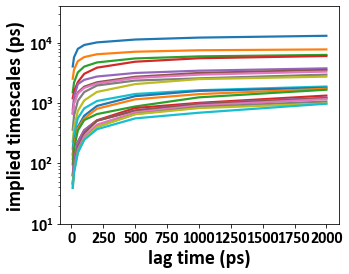

In [17]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*10, msm_timescales[:,i]*10,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ps)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ps)',fontproperties=font_prop)
plt.ylim(10,40000)
plt.semilogy()
plt.savefig('impliedtimescales_kmedoids_800_dihed2.png',dpi=600,bbox_inches='tight')
plt.show()

In [17]:
msm=MarkovStateModel(lag_time=30,reversible_type='mle', verbose=False)

In [18]:
msm.fit(clustered_trajs)

MarkovStateModel(ergodic_cutoff='on', lag_time=30, n_timescales=None,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=False)

In [20]:
lab_fix=msm.transform(clustered_trajs,mode='fill')

In [22]:
cd micro800_lag30_dihed

/home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag30_dihed


In [23]:
wf=open('Population.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()

In [29]:
import mdtraj.io as mdio
from msmbuilder.io import save_meta,load_meta
save_meta(clustered_trajs,'clustered_trajs.pickl')

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/msmbuilder-3.8.0-py2.7-linux-x86_64.egg/msmbuilder/io/io.py:54: BackupWarning: clustered_trajs.pickl exists. Moving it to clustered_trajs.pickl.bak.1
  BackupWarning)


In [25]:
save_meta(msm,'msm.pickl')

In [171]:
wf=open('xtc_sortname.cs','w')
for i in range(len(xyz)):
    wf.write(str(xyz.filename(i))+'\n')
wf.close()

In [18]:
msm=MarkovStateModel(lag_time=50,reversible_type='mle', verbose=False)
msm.fit(clustered_trajs)
lab_fix=msm.transform(clustered_trajs,mode='fill')

In [35]:
cd ../micro800_lag50_dihed

/home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed


In [36]:
wf=open('Populations.dat','w')
for h in msm.populations_:
    wf.write(str(h)+'\n')
wf.close()

matrix = msm.transmat_
wf=open('matrix.dat','w')
for h in matrix:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()

In [37]:
cp -r ../kmedoids/ ./

In [38]:
import mdtraj.io as mdio
from msmbuilder.io import save_meta,load_meta
save_meta(clustered_trajs,'clustered_trajs.pickl')
save_meta(msm,'msm.pickl')

In [39]:
/home/disk2/wdd/glpf/msm/CKtestV5 -msm msm.pickl -clu clustered_trajs.pickl -dt 10 -T 5

SyntaxError: invalid syntax (<ipython-input-39-d9c861638a1a>, line 1)

In [161]:
cd /home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro15

/home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro15


In [21]:
nMacrostates = 25
lagT = 50
pcca = PCCAPlus.from_msm(msm, n_macrostates=nMacrostates)
macro_trajs = pcca.transform(lab_fix)

Optimization terminated successfully.
         Current function value: -15.668205
         Iterations: 21
         Function evaluations: 4060


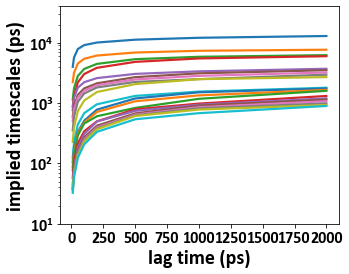

In [22]:
lag_times = np.arange(1,100,2)
lag_times = np.array([1,2,5,10,20,50,100,200])
n_timescales = 20
msm_timescales = implied_timescales(macro_trajs, lag_times, n_timescales=n_timescales, msm=MarkovStateModel(reversible_type='mle',ergodic_cutoff='on',verbose=False), n_jobs = 4)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for i in range(n_timescales):
    plt.plot(lag_times*10, msm_timescales[:,i]*10,lw=2.2)
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'lag time (ps)',fontproperties=font_prop)
plt.ylabel(r'implied timescales (ps)',fontproperties=font_prop)
plt.ylim(10,40000)
plt.semilogy()
plt.savefig('Macro25_impliedtimescales_lag50.png',dpi=600,bbox_inches='tight')
plt.show()

In [164]:
Macromsm = MarkovStateModel(lag_time=50,ergodic_cutoff='off',reversible_type=None)
Macromsm.fit(macro_trajs)

MarkovStateModel(ergodic_cutoff='off', lag_time=50, n_timescales=None,
         prior_counts=0, reversible_type=None, sliding_window=True,
         verbose=True)

In [165]:
wf=open('Macro_Population.dat','w')
for h in Macromsm.populations_:
    wf.write(str(float(h))+'\n')
wf.close()
from msmbuilder.tpt import mfpts
Macro_mfpt = mfpts(Macromsm)
wf=open('Macro_mfpt.dat','w')
for h in Macro_mfpt:
    for l in h:
        wf.write(str(l)+'    ')
    wf.write('\n')
wf.close()
wf=open('tProb.mtx','w')
wf.write('%%MatrixMarket matrix coordinate real general\n%\n')
wf.write(str(len(Macromsm.transmat_))+' '+str(len(Macromsm.transmat_[0]))+' '+str(len(Macromsm.transmat_)*len(Macromsm.transmat_[0]))+'\n')
for i in range(len(Macromsm.transmat_)):
    for j in range(len(Macromsm.transmat_[i])):
        wf.write(str(i+1)+' '+str(j+1)+' '+str(Macromsm.transmat_[i][j])+'\n')
wf.close()

In [118]:
from msmbuilder.tpt import mfpts

Object `mfpt` not found.


In [119]:
mfpts?

In [166]:
save_meta(Macromsm,'Macromsm.pickl')

In [167]:
save_meta(macro_trajs,'macro_trajs.pickl')

In [168]:
from msmbuilder.tpt import hub_scores
hubscore=hub_scores(Macromsm)

In [169]:
hubscore

array([ 0.11731969,  0.20486307,  0.09933435,  0.07749582,  0.29584341,
        0.18374878,  0.29538704,  0.2141879 ,  0.49623107,  0.35408951,
        0.42640737,  0.33328961,  0.48145559,  0.63247293,  0.78851854])

In [57]:
cd /home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro25

/home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro25


In [170]:
wf=open('Macro15_hubScores.dat','w')
for h in hubscore:
    wf.write(str(h)+'\n')
wf.close()

In [59]:
lab_traj=load_meta('macro_trajs.pickl')

In [61]:
M = load_meta('Macromsm.pickl')

In [62]:
M

MarkovStateModel(ergodic_cutoff='on', lag_time=50, n_timescales=None,
         prior_counts=0, reversible_type=None, sliding_window=True,
         verbose=True)

In [175]:
cd /home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro25/temp

/home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro25/temp


In [119]:
xyz_trj = dataset("./*_sample.xtc",topology='crystal.pdb',stride=1)
featurizer_s = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_s = xyz_trj.fit_transform_with(featurizer_s, 'diheds_s/',fmt='dir-npy')

In [89]:
wf=open('xtc_sortname.cs','w')
for i in range(len(xyz_trj)):
    wf.write(str(xyz_trj.filename(i))+'\n')
wf.close()

In [176]:
diheds_s[24][0]/3.14*180

array([ -58.83769226,  -93.05335999,  -84.4586792 ,  -78.5776062 ,
        -83.60604095,  138.26737976,  124.20178223,  140.98629761,
        157.10531616], dtype=float32)

In [126]:
xyz_c = dataset("./crystal.pdb",topology='crystal.pdb',stride=1)
featurizer_c = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_c = xyz_c.fit_transform_with(featurizer_c, 'diheds_c/',fmt='dir-npy')

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/mdtraj-1.8.0-py2.7-linux-x86_64.egg/mdtraj/core/trajectory.py:417: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')


In [131]:
crystral_dihed=diheds_c[0][0]/3.14*180

In [177]:
crystral_dihed

array([ -60.02958679, -139.56974792, -129.19688416,  -89.59128571,
       -128.53622437,  148.59483337,  129.79824829,  135.33282471,
        132.82144165], dtype=float32)

In [172]:
#function of rmsd 
def singleSD(nList,refList):
    length=len(nList)
    sumVar=0.0
    for i in range(length):
        sub=nList[i]-refList[i]
        if np.abs(sub)>180:
            sub=360-np.abs(sub)
        sumVar+=sub**2
    return ((float(sumVar)/float((length)))**0.5)

In [178]:
# rmsd of dihedral angle
wf=open('rmsd_dihed.cs','w')
for i in range(25):
    allRmsd=0
    for j in range(len(diheds_s[i])):
        rmsd=singleSD(diheds_s[i][j]/3.14*180,crystral_dihed)
        allRmsd+=rmsd
    aveRmsd=allRmsd/float(len(diheds_s[i]))
    wf.write(str(i)+'    '+str(aveRmsd)+'\n')
wf.close()

In [151]:
#save dihedral angle
for i in range(25):
    wf=open(str(i)+'_dihed.cs','w')
    for j in range(len(diheds_s[i])):
        for k in range(len(diheds_s[i][j])):
            wf.write(str(diheds_s[i][j][k]/3.14*180)+'    ')
        wf.write('\n')
    wf.close()

In [144]:
singleSD(crystral_dihed,crystral_dihed+3)

3.0

In [173]:
pwd

u'/home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro15'

In [155]:
cd ..

/home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro25


In [156]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.colors as colors
import matplotlib as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
font_path = '/home/disk2/wdd/msm/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=20)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('jet_r')
new_cmap = truncate_colormap(cmap, 0.17, 0.81)
cmap2 = plt.get_cmap('jet')
new_cmap2 = truncate_colormap(cmap2, 0.23, 0.86)

data=np.loadtxt('rmsd_hub_population.cs')
rmsd=data[:,0]
hub=data[:,1]
population=data[:,2]
fig = plt.figure(figsize=(5,4.6))
sub = fig.add_subplot(1,1,1)
p=plt.scatter(rmsd,hub, c=population,cmap=new_cmap2,lw = 0,s=60)
plt.xlabel(r'rmsd ($^\circ$)',fontproperties=font_prop)
plt.ylabel(r'hub score',fontproperties=font_prop)
divider = make_axes_locatable(sub)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(p,cax, orientation='vertical',label='population')

In [179]:
cd /home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro15/temp

/home/disk2/wdd/PDZ/MSM/charm36m/micro800_lag50_dihed/macro15/temp


In [180]:
xyz_trj = dataset("./*_sample.xtc",topology='crystal.pdb',stride=1)
featurizer_s = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_s = xyz_trj.fit_transform_with(featurizer_s, 'diheds_s/',fmt='dir-npy')

In [181]:
xyz_c = dataset("./crystal.pdb",topology='crystal.pdb',stride=1)
featurizer_c = DihedralFeaturizer(types=['phi', 'psi'],sincos=False)
diheds_c = xyz_c.fit_transform_with(featurizer_c, 'diheds_c/',fmt='dir-npy')

In [182]:
crystral_dihed=diheds_c[0][0]/3.14*180

In [184]:
crystral_dihed

array([ -60.02958679, -139.56974792, -129.19688416,  -89.59128571,
       -128.53622437,  148.59483337,  129.79824829,  135.33282471,
        132.82144165], dtype=float32)

In [185]:
# rmsd of dihedral angle
wf=open('rmsd_dihed.cs','w')
for i in range(15):
    allRmsd=0
    for j in range(len(diheds_s[i])):
        rmsd=singleSD(diheds_s[i][j]/3.14*180,crystral_dihed)
        allRmsd+=rmsd
    aveRmsd=allRmsd/float(len(diheds_s[i]))
    wf.write(str(i)+'    '+str(aveRmsd)+'\n')
wf.close()

In [3]:
mfpts?

In [2]:
from msmbuilder.tpt import mfpts

/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/software/anaconda2/envs/msmb/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
from msmbuilder.tpt import mfpt

In [23]:
import mdtraj as md

In [24]:
dirname='/home/dongdong/SCR/msm_pdz/isolation/charm36m/micro800_lag50_dihed/macro25/temp/'


In [57]:
cd /home/dongdong/SCR/msm_pdz/isolation/charm36m/micro800_lag50_dihed/macro25/temp/

/scratch/gpfs/dongdong/msm_pdz/isolation/charm36m/micro800_lag50_dihed/macro25/temp


In [31]:
for i in range(25):
    trjname=str(i)+'_sample.xtc'
    trj=md.load(trjname, top='crystal.pdb')
    j=0
    for tt in trj:
        pdbname=str(i)+'/'+str(i)+'_'+str(j)+'.pdb'
        tt.save_pdb(pdbname)
        j+=1

In [58]:
population=np.loadtxt('../Macro_Population.dat')

In [59]:
import os
total_num=1000
for i in range(len(population)):
    num=int(round(total_num*population[i]))
    if num>0:
        for j in range(num):
            name=str(i)+'/'+str(i)+'_'+str(j)+'.pdb'
            os.system('cp %s ensemble2/' %name)

In [37]:
population

array([ 0.00266158,  0.00433294,  0.00291431,  0.00305935,  0.00394079,
        0.00501316,  0.00516234,  0.00664703,  0.01009595,  0.00750665,
        0.00765597,  0.01237715,  0.0127657 ,  0.01207153,  0.01442228,
        0.02464911,  0.02431564,  0.03307935,  0.03673192,  0.04685185,
        0.08252733,  0.05514205,  0.08156161,  0.13061382,  0.37390058])

In [206]:
cd /home/dongdong/SCR/software/SESCA_v093/test

/scratch/gpfs/dongdong/software/SESCA_v093/test


In [39]:
cddata=np.loadtxt('Compare_CD_auto.out')

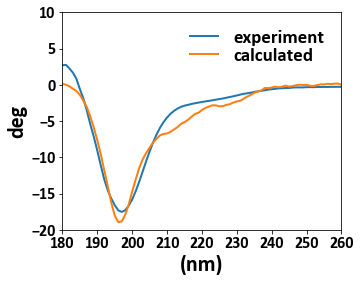

In [75]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
cddata=np.loadtxt('Compare_CD_auto2_DS-simF.out')
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=22)
leg_prop = font_manager.FontProperties(fname=font_path, size=19)
fig = plt.figure(figsize=(5,4))

sub = fig.add_subplot(1,1,1)

plt.plot(cddata[:,0], cddata[:,1],lw=2,label='experiment')
plt.plot(cddata[:,0],cddata[:,2],lw=2,label='calculated')

for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'(nm)',fontproperties=font_prop)
plt.ylabel(r'deg',fontproperties=font_prop)
plt.ylim(-20,10)
plt.xlim(180,260)
leg=sub.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.1)
#plt.semilogy()
plt.savefig('CD.png',dpi=600,bbox_inches='tight')
plt.show()

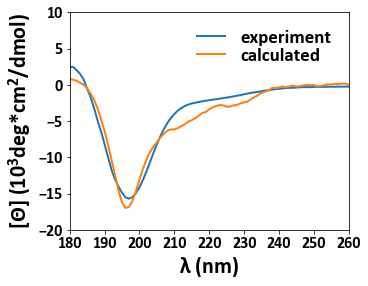

In [76]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
cddata=np.loadtxt('Compare_CD_auto2_DS3-1.out')
plt.plot(cddata[:,0], cddata[:,1],lw=2,label='experiment')
plt.plot(cddata[:,0],cddata[:,2],lw=2,label='calculated')

for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
plt.xlabel(r'$\mathregular{\lambda}$ (nm)',fontproperties=font_prop)
plt.ylabel(r'[$\mathregular{\Theta}$] ($\mathregular{10^3}$deg*$\mathregular{cm^2}$/dmol)',fontproperties=font_prop)
plt.ylim(-20,10)
plt.xlim(180,260)
leg=sub.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.1)
#plt.semilogy()
plt.savefig('CD.png',dpi=600,bbox_inches='tight')
plt.show()

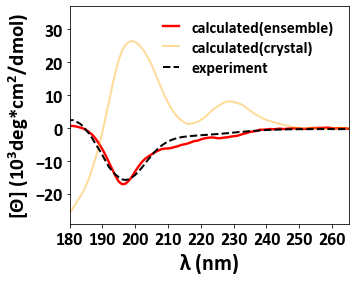

In [210]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
cddata=np.loadtxt('Compare_CD_auto2_DS-simF.out')
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=22)
yl_prop = font_manager.FontProperties(fname=font_path, size=21)
leg_prop = font_manager.FontProperties(fname=font_path, size=16)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
cddata=np.loadtxt('Compare_CD_auto_DS3-1_cry.out')
cddata2=np.loadtxt('Compare_CD_auto2_DS3-1.out')

plt.plot(cddata2[:,0],cddata2[:,2],lw=2.4,label='calculated(ensemble)',color='red')
plt.plot(cddata[:,0],cddata[:,2],lw=2,label='calculated(crystal)',color='orange',alpha=0.4)
plt.plot(cddata[:,0], cddata[:,1],'--',lw=2,label='experiment',color='black')
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
plt.xlabel(r'$\mathregular{\lambda}$ (nm)',fontproperties=font_prop)
plt.ylabel(r'[$\mathregular{\Theta}$] ($\mathregular{10^3}$deg*$\mathregular{cm^2}$/dmol)',fontproperties=yl_prop)
plt.ylim(-29,37)
plt.xlim(180,265)
leg=sub.legend(loc=1, labelspacing=0.37, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.1)
#plt.semilogy()
plt.savefig('CD_all.png',dpi=600,bbox_inches='tight')
plt.show()

In [53]:
rf=open('/home/dongdong/SCR/software/SESCA_v093/libs/Basis_sets_t.nfo')

In [54]:
basisset=[]
for line in rf.readlines():
    line=line.strip()
    temp=line.split()[0]
    basisset.append(temp)

In [55]:
basisset

['DSSP-T',
 'DSSP-1',
 'DS3-1',
 'DS6-1',
 'DS5-4',
 'DS-dT',
 'HBSS-3',
 'DSSP-F',
 'DS-simF',
 'Per-1',
 'Seq2-2',
 'DS-dTSC3',
 'DS5-4SC1',
 'DS6-1SC1',
 'DS5-6SC',
 'DSSP-TSC1',
 'DSSP-1SC3',
 'HBSS-3SC1']

In [120]:
cd /home/dongdong/SCR/msm_pdz/isolation/charm36m/micro800_lag50_dihed/macro25

/scratch/gpfs/dongdong/msm_pdz/isolation/charm36m/micro800_lag50_dihed/macro25


In [149]:
Macro_mfpt=np.loadtxt('Macro_mfpt.dat')/2
Macro_mfpt2=np.maximum(Macro_mfpt, 1)

In [150]:
Macro_mfpt2

array([[   1.        ,  149.74319967,  280.80791024,  463.13945361,
         244.57907792,  190.01531668,  650.69467391,  338.0661509 ,
          90.84488643,  398.95297218,  929.11019168,  143.19997826,
          63.37782841,   83.32771378,   81.60238332,  275.64751733,
         148.81376293,   39.55206021,   35.98388332,   51.75252598,
          19.46020256,   95.48717278,   33.91800525,   17.70242683,
          11.46289396],
       [ 487.59487669,    1.        ,  286.88883628,  457.9149725 ,
         247.52497807,  269.19049516,  646.28739179,  332.79131668,
          87.11010237,  423.12964756,  924.98567107,  140.93111022,
         112.23889234,  203.99413638,   80.58890485,  270.38320061,
         150.5789974 ,   44.84249028,   30.77391579,   52.41878431,
          14.65524528,   92.48542377,   30.83776776,   17.39885806,
           5.50853001],
       [ 488.5195898 ,  154.84928112,    1.        ,  459.14974149,
         266.08085023,  276.52757505,  652.86609992,  334.27211579,


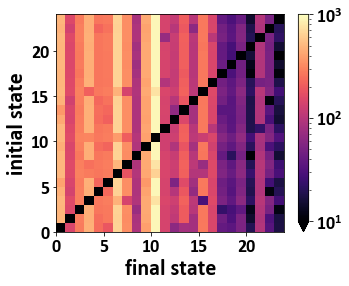

In [198]:
import matplotlib as mpl

import matplotlib as mpl
from matplotlib import ticker, cm
#from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm
font_prop = font_manager.FontProperties(fname=font_path, size=22)
leg_prop = font_manager.FontProperties(fname=font_path, size=18)
fig = plt.figure(figsize=(5.1, 4))
ax = fig.add_subplot(111)
cmap = plt.cm.get_cmap("magma")
#CS = plt.contourf(xedges[1:],yedges[1:],H,levels = np.linspace(0,1000000,11),cmap=cmap,extend="max")
#lvls = np.logspace(0,3,15)
cmap.set_over("black")
#CS = plt.contourf(np.arange(len(Macro_mfpt)),np.arange(len(Macro_mfpt)),Macro_mfpt2,levels = [1,10,50,100,500,1000],cmap=cmap,extend="min",norm = LogNorm())
#cbar = plt.colorbar(CS)
p=plt.pcolormesh(np.arange(len(Macro_mfpt)),np.arange(len(Macro_mfpt)),Macro_mfpt2,norm = LogNorm(),cmap=cmap,vmax=1000,vmin=10)
#plt.imshow(np.arange(len(Macro_mfpt)),np.arange(len(Macro_mfpt)),Macro_mfpt,norm = LogNorm(),cmap=cmap)
cbar=plt.colorbar(p, extend='min') 
#cbar = plt.colorbar()
#plt.scatter(data_ave[:,0],data_ave[:,1],s=18)
#plt.scatter(data_ave[:,0],data_ave[:,1],c=pcca,cmap='tab20c',s=14)
#plt.errorbar(data_ave[:,2],data_ave[:,0],xerr=data_ave[:,3],yerr=data_ave[:,1],fmt=None)
plt.xlabel(r'final state',fontproperties=font_prop)
plt.ylabel(r'initial state',fontproperties=font_prop)
#plt.xlim(0,0.45)
#plt.ylim(0,1)
#leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
#leg.get_frame().set_linewidth(0.0)
#leg.get_frame().set_alpha(0.1)
for label in (ax.get_xticklabels() + ax.get_yticklabels()+cbar.ax.get_yticklabels()):
    label.set_fontproperties(leg_prop)
plt.savefig('/home/dongdong/SCR/msm_pdz/isolation/charm36m/micro800_lag50_dihed/macro25/Mfpt.png',dpi=600,bbox_inches='tight')
plt.show()


Text(33.0, 0.5, 'macrostate index')

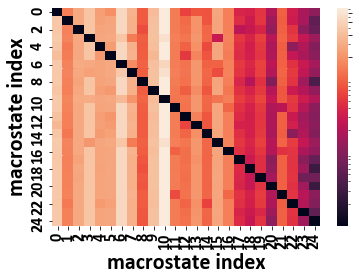

In [162]:
import seaborn as sns
ax = sns.heatmap(Macro_mfpt2,norm = LogNorm())
for label in (ax.get_xticklabels() + ax.get_yticklabels()+cbar.ax.get_yticklabels()):
    label.set_fontproperties(leg_prop)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(leg_prop)
plt.xlabel(r'macrostate index',fontproperties=font_prop)
plt.ylabel(r'macrostate index',fontproperties=font_prop)

In [185]:
hub_score=np.loadtxt('rmsd_hub_population.cs')[:,1]

1.0

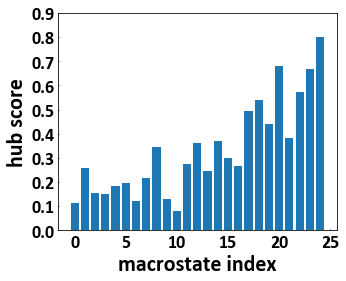

In [205]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=22)
leg_prop = font_manager.FontProperties(fname=font_path, size=17)
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
x=np.arange(25)
hub_score=np.loadtxt('rmsd_hub_population.cs')[:,1]
plt.bar(x, hub_score,lw=2)
#plt.bar(mfpt, isop,lw=2,label='isolation',alpha=0.8)
#plt.bar(x, hub_score,lw=2,label='Q < 0.01',width = 0.4)
#plt.plot(mfpt, q2,'o-',lw=2,label='0.10 < Q < 0.20',alpha=0.8)

for label in ( sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
for label in (sub.get_xticklabels() ):
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
plt.xlabel(r'macrostate index',fontproperties=font_prop)
sub.tick_params(direction="in", length=1)
#plt.xticks(x,(['24','20','18','8','23','1','17','2','19','22','4','14','12','13','11','5','21','0','16','9','7','3','15','6','10']),rotation=90)
plt.ylabel(r'hub score',fontproperties=font_prop)
plt.ylim(0,0.9)
#plt.xlim(0,25)
#leg=sub.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
#leg.get_frame().set_linewidth(0.0)
#leg.get_frame().set_alpha(0.1)
#plt.semilogy()
plt.savefig('hub_score.png',dpi=600,bbox_inches='tight')
plt.show()

In [216]:
all_mfpt=Macro_mfpt.reshape(1,-1)[0]

Text(0, 0.5, 'frequency')

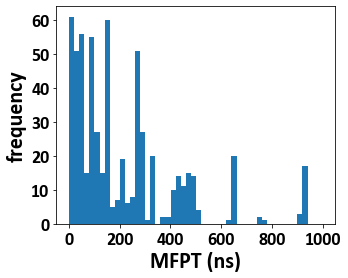

In [224]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
sub.hist(all_mfpt,bins=50,range=(1, 1000))
for label in ( sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
for label in (sub.get_xticklabels() ):
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
plt.xlabel(r'MFPT (ns)',fontproperties=font_prop)
plt.ylabel(r'frequency',fontproperties=font_prop)